# Gem Puzzle

## Global code

In [1]:
import numpy as np
from collections import deque, namedtuple
import timeit
from random import choice
import heapq
from tqdm import tqdm
import matplotlib.pyplot as plt


'''Puzzle initial settings'''
# Set puzzle size 
PUZZLE_DIM = 3  

# Goal State Setup
GoalState = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
action = namedtuple('Action', ['direction', 'pos1', 'pos2'])




'''Puzzle helper classes'''
# PuzzleState class that holds information about the state and search metadata
class PuzzleState:
    def __init__(self, state, parent=None, move=None, depth=0, cost=0, key=0):
        self.state = state
        self.parent = parent
        self.move = move  # Move is a string ('up', 'down', 'left', 'right')
        self.depth = depth
        self.cost = cost  # Number of nodes expanded so far
        self.key = key
        self.map = state.tobytes()

    def __eq__(self, other):
        return self.map == other.map

    def __lt__(self, other):
        """For heapq to prioritize states based on the key."""
        return self.key < other.key

# Abstract Search Algorithm Class
class PuzzleSearch:
    def __init__(self, start_state):
        self.start_state = start_state
        self.goal_node = None
        self.max_frontier_size = 0
        self.max_search_depth = 0
        self.nodes_expanded = 0
        self.path = []

    def reconstruct_path(self):
        """Reconstruct the solution path by tracing the parent pointers."""
        node = self.goal_node
        while node and node.parent:
            self.path.insert(0, node.move)  # Action is the string ('up', 'down', 'left', 'right')
            node = node.parent

    def get_metrics(self):
        """Returns the metrics for the search."""
        return {
            "quality": len(self.path),  # Number of actions in the solution
            "cost": self.nodes_expanded,  # Total nodes evaluated
        }


## Helper Functions

In [2]:
def available_actions(state: np.ndarray) -> list:
    """Returns a list of possible actions (state transitions) for the current state."""
    x, y = np.where(state == 0)[0][0], np.where(state == 0)[1][0]
    actions = []
    if x > 0: actions.append(action('up', (x, y), (x - 1, y)))  # Move up
    if x < PUZZLE_DIM - 1: actions.append(action('down', (x, y), (x + 1, y)))  # Move down
    if y > 0: actions.append(action('left', (x, y), (x, y - 1)))  # Move left
    if y < PUZZLE_DIM - 1: actions.append(action('right', (x, y), (x, y + 1)))  # Move right
    return actions

def do_action(state: np.ndarray, action) -> np.ndarray:
    """Performs an action on the given state and returns the new state."""
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

# Heuristic for A* (Manhattan Distance)
def manhattan_heuristic(state: np.ndarray) -> int:
    """Returns the Manhattan Distance heuristic for the given state."""
    distance = 0
    for i in range(PUZZLE_DIM):
        for j in range(PUZZLE_DIM):
            value = state[i, j]
            if value != 0: # Skip the empty tile
                target_x, target_y = divmod(value - 1, PUZZLE_DIM)
                distance += abs(target_x - i) + abs(target_y - j)
    return distance

# Function to format the results
def format_results(algorithm, initial_state, search, metrics, execution_time):
    # Formatting the results into a string
    result_str = f"""
Algorithm: {algorithm}
Initial State:
{initial_state}

Path to goal: {search.path}
Quality (path length): {metrics['quality']}
Cost (nodes evaluated): {metrics['cost']}
Running time: {execution_time:.8f} seconds
    """
    return result_str

# Print and save the results
def print_and_save_results(algorithm, initial_state, search, metrics, execution_time):
    # Get the formatted results
    result_str = format_results(algorithm, initial_state, search, metrics, execution_time)

    # Print the results to console
    print(result_str)

    # Save the results to a file
    with open('output.txt', 'a') as file:
        file.write(result_str)


## Path-search algorithms
In the follow BFS, DFS and A* algorithms are presented.

### BFS Search

In [3]:
class BFS(PuzzleSearch):
    def run(self):
        board_visited = set()
        queue = deque([PuzzleState(self.start_state)])
        progress = tqdm(total=1, desc="BFS Progress", unit="node", dynamic_ncols=True)

        while queue:
            node = queue.popleft()
            board_visited.add(node.map)
            self.nodes_expanded += 1  # Increment the number of nodes expanded
            node.cost = self.nodes_expanded  # Update the node's cost (nodes expanded)
            progress.update(1)

            if np.array_equal(node.state, GoalState):
                progress.close()
                self.goal_node = node
                self.reconstruct_path()
                return

            for act in available_actions(node.state):
                new_state = do_action(node.state, act)
                new_node = PuzzleState(new_state, node, act.direction, node.depth + 1)  # Use action direction as move
                if new_node.map not in board_visited:
                    queue.append(new_node)
                    board_visited.add(new_node.map)
                    self.max_frontier_size = max(self.max_frontier_size, len(queue))
                    self.max_search_depth = max(self.max_search_depth, new_node.depth)

        progress.close()

### DFS Search

In [4]:
class DFS(PuzzleSearch):
    def run(self):
        board_visited = set()
        stack = [PuzzleState(self.start_state)]
        progress = tqdm(total=1, desc="DFS Progress", unit="node", dynamic_ncols=True)

        while stack:
            node = stack.pop()
            board_visited.add(node.map)
            self.nodes_expanded += 1  # Increment the number of nodes expanded
            node.cost = self.nodes_expanded  # Update the node's cost (nodes expanded)
            progress.update(1)

            if np.array_equal(node.state, GoalState):
                progress.close()
                self.goal_node = node
                self.reconstruct_path()
                return

            for act in reversed(available_actions(node.state)):
                new_state = do_action(node.state, act)
                new_node = PuzzleState(new_state, node, act.direction, node.depth + 1)  # Use action direction as move
                if new_node.map not in board_visited:
                    stack.append(new_node)
                    board_visited.add(new_node.map)
                    self.max_frontier_size = max(self.max_frontier_size, len(stack))
                    self.max_search_depth = max(self.max_search_depth, new_node.depth)

        progress.close()

### A* Search

In [5]:
class AStar(PuzzleSearch):
    def run(self):
        board_visited = set()
        initial_key = manhattan_heuristic(self.start_state)
        queue = [PuzzleState(self.start_state, key=initial_key)]
        heapq.heapify(queue)
        progress = tqdm(total=1, desc="A* Progress", unit="node", dynamic_ncols=True)

        while queue:
            node = heapq.heappop(queue)
            self.nodes_expanded += 1  # Increment the number of nodes expanded
            node.cost = self.nodes_expanded  # Update the node's cost (nodes expanded)
            progress.update(1)

            if np.array_equal(node.state, GoalState):
                progress.close()
                self.goal_node = node
                self.reconstruct_path()
                return

            for act in available_actions(node.state):
                new_state = do_action(node.state, act)
                new_node = PuzzleState(new_state, node, act.direction, node.depth + 1)  # Use action direction as move
                if new_node.map not in board_visited:
                    new_node.key = manhattan_heuristic(new_state) + new_node.depth
                    heapq.heappush(queue, new_node)
                    board_visited.add(new_node.map)
                    self.max_frontier_size = max(self.max_frontier_size, len(queue))
                    self.max_search_depth = max(self.max_search_depth, new_node.depth)

        progress.close()

### Run the algorithms

Randomizing: 100%|██████████| 100/100 [00:00<?, ?it/s]
A* Progress: 700node [00:00, 7097.53node/s]         



Algorithm: AStar
Initial State:
[[8 6 5]
 [2 4 3]
 [0 1 7]]

Path to goal: ['right', 'up', 'up', 'right', 'down', 'left', 'up', 'left', 'down', 'down', 'right', 'right', 'up', 'left', 'up', 'left', 'down', 'down', 'right', 'up', 'right', 'down']
Quality (path length): 22
Cost (nodes evaluated): 700
Running time: 0.10939980 seconds
    


BFS Progress: 86437node [00:03, 22116.98node/s]      



Algorithm: BFS
Initial State:
[[8 6 5]
 [2 4 3]
 [0 1 7]]

Path to goal: ['right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'right', 'down', 'left', 'down', 'right', 'up', 'left', 'up', 'left', 'down', 'down', 'right', 'right']
Quality (path length): 22
Cost (nodes evaluated): 86437
Running time: 3.97290080 seconds
    


DFS Progress: 92817node [00:03, 24931.74node/s]      



Algorithm: DFS
Initial State:
[[8 6 5]
 [2 4 3]
 [0 1 7]]

Path to goal: ['up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'down', 'left', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'right', 'right', 'down', 'down', 'left', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'right', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'right', 'down', 'down', 'left', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'down', 'right', 'up', 'up', 'left', 'down', 'right', 'up', '

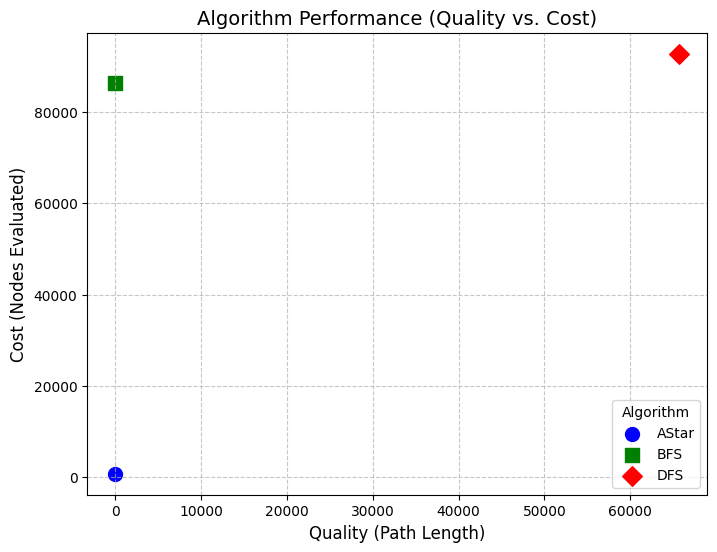

In [6]:
# Create scrambled initial state
initial_state = GoalState.copy()
randomize_steps = 100  # Number of random moves to scramble
for _ in tqdm(range(randomize_steps), desc="Randomizing"):
    initial_state = do_action(initial_state, choice(available_actions(initial_state)))

search = None

# Store results for plotting
results = []

for Alg in [AStar, BFS, DFS]:
    # Run the search and time it
    search = Alg(initial_state)

    start = timeit.default_timer()
    search.run()
    stop = timeit.default_timer()

    # Calculate execution time
    execution_time = stop - start

    # Get metrics
    metrics = search.get_metrics()
    quality = metrics['quality']
    cost = metrics['cost']

    # Append results for plotting
    results.append({
        "algorithm": Alg.__name__,
        "quality": quality,
        "cost": cost,
    })

    # Print and save the results
    print_and_save_results(Alg.__name__, initial_state, search, metrics, execution_time)

# Generate a scatter plot
plt.figure(figsize=(8, 6))

# Define markers and colors for each algorithm
colors = {"AStar": "blue", "BFS": "green", "DFS": "red"}
markers = {"AStar": "o", "BFS": "s", "DFS": "D"}

for result in results:
    algorithm = result["algorithm"]
    quality = result["quality"]
    cost = result["cost"]

    # Plot each point with its respective color and marker
    plt.scatter(
        quality, cost,
        color=colors[algorithm],
        marker=markers[algorithm],
        label=algorithm,
        s=100  # Size of the marker
    )

# Add labels and title
plt.xlabel("Quality (Path Length)", fontsize=12)
plt.ylabel("Cost (Nodes Evaluated)", fontsize=12)
plt.title("Algorithm Performance (Quality vs. Cost)", fontsize=14)

# Add a legend
plt.legend(title="Algorithm", fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()